In [1]:
from random import choice
from pprint import pprint
import pandas as pd
import numpy as np
import seaborn as sns
import math
from kaggle_environments import evaluate, make
from kaggle_environments.envs.halite.helpers import *

In [2]:
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

# To DO
- Safe spawn
- Nearest shipyard
- Multiple shipyards
- Pirate ships
- Enemy avoidance
- Metaboard for traveling past the edge

In [3]:
class myship:
    def __init__(self,ship):
        self.player_id=ship.player_id
        self.position=ship.position
        self.next_position=None
        self.state = 1
        self.id = ship.id
        self.halite = ship.halite
        self.stats = {}
        self.ddf=[]
        self.next_action=None
        self.statemap={1:"idle",2:"move_mining",3:"mining",
                       4:"move_depositing",5:"depositing",6:"create_shipyard",
                       7:"converting",8:"destroyed",101:"mining_spot"}
        self.moving_to=None
        
        
        ### Controls
        self.dist_weight=2            # weight for halite/distance calculation
        self.max_shiphalite=1000      # How much a ship should collect before returning
        self.min_cellhalite=50        # How much halite a cell should have for (continue) mining
        
    def point_from_index(self,index,size=21):
        y, x = divmod(index, size)
        return (x, (size - y - 1))
    
    def index_from_point(self,point,size=21):
        return (size - point[1] - 1) * size + point[0]
    
    def update_miningspot(self,cb):
        if self.state in [2,3]:
            cb[self.moving_to[1],self.moving_to[0]]=101
    
    def get_best_halite(self,obs,cb):
        best_halite={}
        best_halite["amount"]=0
        best_halite["pos"]=None
        
        for ix,halite in enumerate(obs.halite):          
            halite_pos=self.point_from_index(ix)
            
            if cb[halite_pos[1],halite_pos[0]] not in [3,101] and halite>=self.min_cellhalite:
                #distance to halite
                dist = math.sqrt(abs(halite_pos[1] - self.position[1]) + abs(halite_pos[0] - self.position[0]))
                dist_value=float(halite)/float(dist+0.0001*self.dist_weight)
                if dist_value>best_halite["amount"]:
                    best_halite["amount"]=dist_value
                    best_halite["pos"]=halite_pos
                    
        return best_halite["pos"]
    
    
    def getCompass(self,o_x,o_y,d_x,d_y):

        delta_x=d_x-o_x
        delta_y=d_y-o_y

        degrees = math.atan2(delta_x, delta_y)/math.pi*180

        alt=[degrees,degrees+90,degrees-90]

        for i,a in enumerate(alt):
            if a < 0:
                alt[i]=a+360

        directions=[["NORTH"],["NORTH","EAST"],["EAST"],["SOUTH","EAST"],["SOUTH"],["SOUTH","WEST"],["WEST"],["NORTH","WEST"],["NORTH"]]

        return directions[round(alt[0]/45)],directions[round(alt[1]/45)],directions[round(alt[2]/45)]   
    
    
    def update_next_action(self,cb):
        
        if self.moving_to == self.position:
            self.next_action=None
            self.next_position=self.position
        
        ddict={}
        ddict["NORTH"]=(self.position[0],self.position[1]+1)
        ddict["SOUTH"]=(self.position[0],self.position[1]-1)
        ddict["EAST"]=(self.position[0]+1,self.position[1])
        ddict["WEST"]=(self.position[0]-1,self.position[1])
        
        prio,alt1,alt2 = self.getCompass(self.position[0],self.position[1],self.moving_to[0],self.moving_to[1])
        alt=alt1+alt2
        
        for direction in prio:
            pos=ddict[direction]
            if cb[pos[1],pos[0]] in [1,2,3,4]:
                continue
            else:
                self.next_action=direction
                self.next_position=ddict[direction]
                return
            
        for direction in alt:
            pos=ddict[direction]
            if cb[pos[1],pos[0]] in [1,2,3,4]:
                continue
            else:
                self.next_action=direction
                self.next_position=ddict[direction]
                return
        
        self.next_action = None
        self.next_position=self.position
    
    
    def update(self,obs):
        self.position=self.point_from_index(obs.players[self.player_id][2][self.id][0])
        self.halite = obs.players[self.player_id][2][self.id][1]
            
    def log_stats(self,obs):
        row={}
        row["step"]=obs.step
        row["id"]=self.id
        row["position"]=self.position
        row["moving_to"]=self.moving_to
        row["state"]=self.statemap[self.state]
        row["halite"]=self.halite
        row["global_halite"]=obs.players[self.player_id][0]
        row["next_action"]=self.next_action
        row["next_position"]=self.next_position
        self.stats=row
        self.ddf.append(row)

    def update_checkboard(self,cb):
        x=self.next_position[0]
        y=self.next_position[1]
        cb[y][x]=self.state
        
    def check_destroyed(self,obs):
        return not self.id  in list(obs.players[self.player_id][2].keys())
    
    def set_action(self,obs,cb):
        if len(obs.players[self.player_id][1])==0:
            self.next_action="CONVERT"
            self.state=7
            return    
        
        # If Idle go mining
        if self.state==1:
            best_mining_spot=self.get_best_halite(obs,cb)
            self.moving_to=best_mining_spot
            cb[best_mining_spot[1],best_mining_spot[0]]=101
            self.state=2
        
        
        if self.state==2:
            if self.position==self.moving_to:
                self.next_action=None
                self.next_position=self.position
                self.state=3
                
        if self.state==3:
            if obs.halite[self.index_from_point(self.position)]<=self.min_cellhalite:
                if self.halite>=self.max_shiphalite:
                    self.moving_to=self.point_from_index(list(obs.players[self.player_id][1].values())[0])
                    self.state=4
                else: 
                    self.state=1
        
        if self.state==4:
            if self.position==self.moving_to:
                self.state=1
            
        if self.state==1:
            best_mining_spot=self.get_best_halite(obs,cb)
            self.moving_to=best_mining_spot
            cb[best_mining_spot[1],best_mining_spot[0]]=101
            self.state=2
            
        if self.state in [2,4]:
            self.update_next_action(cb)
        
        
        #self.next_action=choice(["NORTH","EAST","SOUTH","WEST",None])
        
        self.update_checkboard(cb)
        
        
        
shipids=[]
ship_list=[]

stats=[]

def agent(obs, conf):
    global stats
    checkboard=np.zeros((21,21))
    board=Board(obs,conf)
    me = board.current_player
    action={}    
    
    #check for new ships
    for ship in me.ships:
        if ship.id not in shipids:
            ship_list.append(myship(ship))
            shipids.append(ship.id)
    
    for ship in ship_list:
        #check if ship is destroyed
        if ship.check_destroyed(obs):
            ship.state=8
            ship_list.remove(ship)
            ship.log_stats(obs)
            stats.append(ship.stats)
            continue
        
        #update info
        ship.update(obs)
        
        #update cb
        ship.update_miningspot(checkboard)
        
    for ship in ship_list:
        
        #get action
        ship.set_action(obs,checkboard)
        if ship.next_action != None:
            action[ship.id]=ship.next_action
        
        #if next action is convert then remove from shiplist next round
        if ship.next_action=="CONVERT":
            ship_list.remove(ship)
        
        #logging and collect stats
        ship.log_stats(obs)
        stats.append(ship.stats)
        
    for shipyard in me.shipyards:
        if len(ship_list)<6:
            action[shipyard.id]="SPAWN"
        
    
    return action

In [4]:
env = make("halite", debug=True)
trainer = env.train([None, "random"])
observation = trainer.reset()
while not env.done and observation.step<500:
    my_action = agent(observation, env.configuration)
    print(f"Step: {observation.step} | My Action {my_action}")
    observation = trainer.step(my_action)[0]

Step: 0 | My Action {'0-1': 'CONVERT'}
Step: 1 | My Action {'1-1': 'SPAWN'}
Step: 2 | My Action {'2-1': 'NORTH', '1-1': 'SPAWN'}
Step: 3 | My Action {'2-1': 'NORTH', '3-1': 'SOUTH', '1-1': 'SPAWN'}
Step: 4 | My Action {'2-1': 'EAST', '3-1': 'SOUTH', '4-1': 'NORTH', '1-1': 'SPAWN'}
Step: 5 | My Action {'3-1': 'EAST', '4-1': 'NORTH', '5-1': 'SOUTH', '1-1': 'SPAWN'}
Step: 6 | My Action {'4-1': 'SOUTH', '5-1': 'SOUTH', '6-1': 'WEST', '1-1': 'SPAWN'}
Step: 7 | My Action {'4-1': 'NORTH', '5-1': 'SOUTH', '6-1': 'NORTH', '7-1': 'SOUTH'}
Step: 8 | My Action {'4-1': 'SOUTH', '5-1': 'NORTH', '6-1': 'WEST', '7-1': 'WEST'}
Step: 9 | My Action {'4-1': 'NORTH', '5-1': 'SOUTH', '7-1': 'WEST'}
Step: 10 | My Action {'4-1': 'SOUTH', '5-1': 'NORTH'}
Step: 11 | My Action {'4-1': 'NORTH', '5-1': 'SOUTH'}
Step: 12 | My Action {'4-1': 'SOUTH', '5-1': 'NORTH'}
Step: 13 | My Action {'2-1': 'WEST', '4-1': 'EAST', '5-1': 'SOUTH'}
Step: 14 | My Action {'2-1': 'WEST', '3-1': 'WEST', '4-1': 'NORTH', '5-1': 'EAST'}
S

Step: 128 | My Action {'3-1': 'NORTH', '25-1': 'NORTH', '48-3': 'EAST'}
Step: 129 | My Action {'3-1': 'EAST', '25-1': 'WEST', '48-3': 'EAST'}
Step: 130 | My Action {'3-1': 'EAST', '25-1': 'WEST', '48-1': 'NORTH', '48-3': 'EAST'}
Step: 131 | My Action {'25-1': 'SOUTH', '48-1': 'NORTH', '48-3': 'EAST'}
Step: 132 | My Action {'25-1': 'SOUTH', '48-1': 'NORTH', '48-2': 'EAST'}
Step: 133 | My Action {'6-1': 'EAST', '25-1': 'SOUTH', '48-1': 'NORTH'}
Step: 134 | My Action {'48-1': 'NORTH'}
Step: 135 | My Action {'48-1': 'NORTH'}
Step: 136 | My Action {'48-1': 'NORTH'}
Step: 137 | My Action {'48-1': 'NORTH'}
Step: 138 | My Action {'48-1': 'WEST'}
Step: 139 | My Action {'48-1': 'SOUTH'}
Step: 140 | My Action {'3-1': 'EAST', '48-1': 'SOUTH'}
Step: 141 | My Action {'3-1': 'EAST', '6-1': 'SOUTH', '25-1': 'SOUTH', '48-1': 'EAST', '48-3': 'NORTH'}
Step: 142 | My Action {'3-1': 'SOUTH', '25-1': 'SOUTH', '48-1': 'EAST', '48-2': 'NORTH', '48-3': 'NORTH'}
Step: 143 | My Action {'3-1': 'EAST', '25-1': 'EA

In [5]:
pd.DataFrame(stats)

,step,id,position,moving_to,state,halite,global_halite,next_action,next_position
0,0,0-1,"(5, 10)",None,converting,0,5000,CONVERT,None
1,2,2-1,"(5, 10)","(6, 12)",move_mining,0,4000,NORTH,"(5, 11)"
2,3,2-1,"(5, 11)","(6, 12)",move_mining,0,3500,NORTH,"(5, 12)"
3,3,3-1,"(5, 10)","(6, 8)",move_mining,0,3500,SOUTH,"(5, 9)"
4,4,2-1,"(5, 12)","(6, 12)",move_mining,0,3000,EAST,"(6, 12)"
...,...,...,...,...,...,...,...,...,...
1147,191,48-2,"(2, 8)","(2, 8)",mining,125,22451,None,"(2, 8)"
1148,191,48-3,"(2, 20)","(2, 20)",mining,732,22451,None,"(2, 20)"
1149,191,176-1,"(4, 19)","(4, 19)",mining,116,22451,None,"(4, 19)"
1150,191,176-2,"(6, 16)","(6, 16)",mining,529,22451,None,"(6, 16)"


In [6]:
env.render(mode="ipython",width=800, height=600)

<AxesSubplot:xlabel='step'>

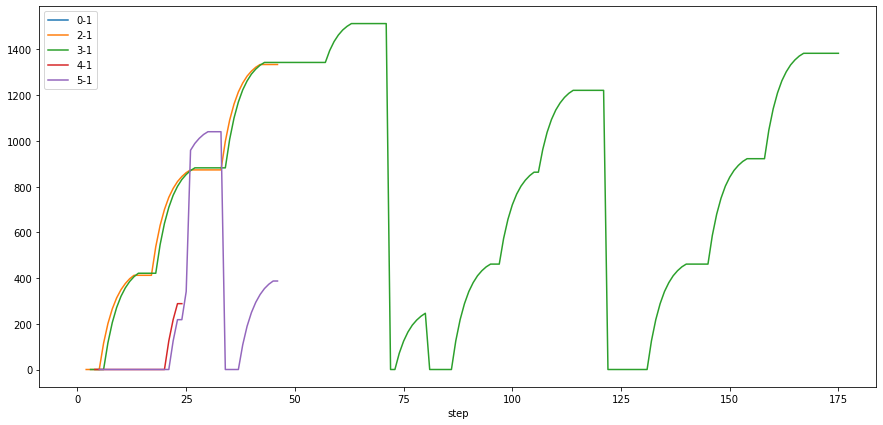

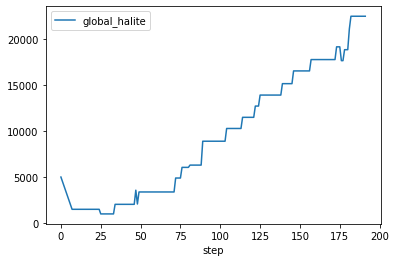

In [8]:
df=pd.DataFrame(stats)
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(15,7))

for cat in df["id"].unique()[:5]:
    df[df["id"]==cat].plot(x="step",y="halite",ax=ax, label=cat)
    
df.plot(x="step",y="global_halite")

In [ ]:
df[df["id"]=="3-1"]